# Euro 2024

In [7]:
import pandas as pd
import numpy as np
from itertools import product


(0, 0, 0)
(0, 0, 1)
(0, 1, 0)
(0, 1, 1)
(1, 0, 0)
(1, 0, 1)
(1, 1, 0)
(1, 1, 1)


In [64]:
# Order is according to bracket structure. Odds from Draftkings
odds = {
    "England": 400,
    "Switzerland": 1400,
    "Netherlands": 700,
    "Turkey": 4000,
    "Spain": 400,
    "Germany": 450,
    "Portugal": 850,
    "France": 450,
}



In [23]:
# Calculate implied probabilities
unnorm_prob = {k: 100 / (100 + v) for k, v in odds.items()}
imp_prob = {
    k: v / sum(uv for _, uv in unnorm_prob.items()) for k, v in unnorm_prob.items()
}


# Calculate tournament win probabilities
def tourney_win_probs(team_ratings: dict[str, float]) -> dict[str, float]:
    t = list(team_ratings)  # just the teams

    # Create win prob matrix--prob team index beats team column
    tr = pd.concat([pd.Series(team_ratings) for _ in range(len(team_ratings))], axis=1)
    tr.columns = t
    mat = 1 / (1 + np.exp(tr.T - tr))

    # Create all combinations of outcomes
    p_win = {k: 0 for k in t}
    for o in product(*[range(2) for _ in range(len(t) - 1)]):
        t_ = list(t)
        p = 1  # Prob tournament plays out this way
        for i, w in enumerate(o):
            t1, t2 = t_[2 * i], t_[2 * i + 1]
            p *= abs(w - mat.loc[t1, t2])  # Prob this match has this outcome
            t_.append([t1, t2][w])
        p_win[t_[-1]] += p

    return p_win


def loss_fn(x: list[float]) -> float:
    t = list(imp_prob)
    team_ratings = {k: x_ for k, x_ in zip(t, x)}
    p_win = tourney_win_probs(team_ratings)

    # Calculate loss
    return sum(abs(imp_prob[team] - p_win[team]) for team in t)

In [24]:
from scipy.optimize import minimize

res = minimize(loss_fn, x0=[0 for _ in imp_prob])
true_ratings = {k: v for k, v in zip(list(imp_prob), res.x)}
p_win = tourney_win_probs(true_ratings)
p_win

{'England': 0.18433923601397603,
 'Switzerland': 0.06144678022805963,
 'Netherlands': 0.115212130174003,
 'Turkey': 0.022480316920729312,
 'Spain': 0.1843391973629434,
 'Germany': 0.16758081726318827,
 'Portugal': 0.0970204791053535,
 'France': 0.16758104293174678}

In [29]:
# Estimate random bracket win probs
n = 1000
t = list(true_ratings)
sim_p_win = {k: 0 for k in t}
for i in range(n):
    shuf = np.random.choice(t, size=len(t), replace=False)
    curr_ratings = {k: true_ratings[k] for k in shuf}
    curr_p_win = tourney_win_probs(curr_ratings)
    for k in t:
        sim_p_win[k] += curr_p_win[k] / n

sim_p_win

{'England': 0.13850505089744153,
 'Switzerland': 0.0517307121944559,
 'Netherlands': 0.07458852818761388,
 'Turkey': 0.017232718908380493,
 'Spain': 0.2170278603223354,
 'Germany': 0.20156454372755891,
 'Portugal': 0.11624814788211661,
 'France': 0.18310243788009734}

## Visualization

In [36]:
team_pic = {
    "England": "ENG",
    "Switzerland": "SUI",
    "Netherlands": "NED",
    "Turkey": "TUR",
    "Spain": "ESP",
    "Germany": "GER",
    "Portugal": "POR",
    "France": "FRA",
}

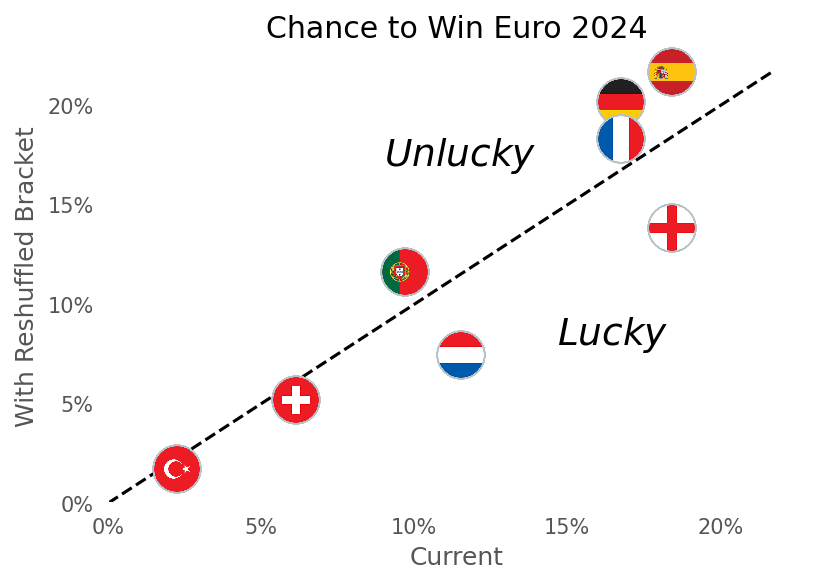

In [60]:
import matplotlib.pyplot as plt
from matplotlib.offsetbox import OffsetImage, AnnotationBbox


plt.style.use("ggplot")


def getImage(path, zoom=0.1):
    return OffsetImage(plt.imread(path), zoom=zoom)


df = pd.DataFrame(
    {
        "curr_p_win": imp_prob,
        "true_p_win": sim_p_win,
    }
)

# Plot
fig, ax = plt.subplots(dpi=150)
mp = df.max().max()
ax.plot([0, mp], [0, mp], c="k", ls="--")
for team in t:
    x0 = df.loc[team, "curr_p_win"]
    y0 = df.loc[team, "true_p_win"]
    ab = AnnotationBbox(
        getImage(f"images/{team_pic[team]}.png"), (x0, y0), frameon=False
    )
    ax.add_artist(ab)
# df.plot.scatter(x="curr_p_win", y="true_p_win", ax=ax)
ax.xaxis.set_major_formatter("{x:.0%}")
ax.yaxis.set_major_formatter("{x:.0%}")
ax.set_xlim(0, None)
ax.set_ylim(0, None)
ax.set_xlabel("Current")
ax.set_ylabel("With Reshuffled Bracket")
ax.set_title("Chance to Win Euro 2024")
ax.set_facecolor("white")
ax.annotate("$\it{Lucky}$", xy=(0.165, 0.085), va="center", ha="center", fontsize=18)
ax.annotate("$\it{Unlucky}$", xy=(0.115, 0.175), va="center", ha="center", fontsize=18)
ax.tick_params(bottom=False, left=False)
plt.show()

In [40]:
df.style.format("{:.1%}")

,curr_p_win,true_p_win
England,18.4%,13.9%
Switzerland,6.1%,5.2%
Netherlands,11.5%,7.5%
Turkey,2.2%,1.7%
Spain,18.4%,21.7%
Germany,16.8%,20.2%
Portugal,9.7%,11.6%
France,16.8%,18.3%


## Odds for First round matchups for validation

In [65]:
def single_game_win_prob(t1: float, t2: float) -> float:
    # Given two team ratings, calculate the win-prob of t1
    return 1 / (1 + np.exp(t2 - t1))


for i in range(8):
    team = t[i]
    opp = t[i - 2 * (i % 2) + 1]
    p = single_game_win_prob(true_ratings[team], true_ratings[opp])
    if p > 0.5:
        odds = f"{-1 * 100 * p / (1 - p):.0f}"
    else:
        odds = f"+{100 * (1 - p)/p:.0f}"
    print(f"{team}: {odds}")

England: -172
Switzerland: +172
Netherlands: -203
Turkey: +203
Spain: -105
Germany: +105
Portugal: +132
France: -132
